# Generating sample paths of alternative abstract models and plotting tipping time estimation results
This notebook will first generate sample paths according to the model descriptions of the abstract models in Ben-Yami et al. 2024. This part does not need to be run, as there are already sample paths available to download. Runtime for 10000 sample paths for all models is about 3h on an Apple M1 chip.

After generating the sample paths, the R script `generalestimation_altModels.Rmd` needs to be run. The files containing results of $t_c$ are automatically saved in the same folder. They are also available for download.

From these results, the histograms are generated.


In [43]:
import time
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.gofplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
mpl.rcdefaults() 

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})


mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#d95f02','#e7298a','#1b9e77','#7570b3','#66a61e','#e6ab02','#a6761d','#666666']) 
figlabels = ["A", "B","", "C", "D", ""]

### Generate sample paths of different models

In [44]:
t_start = 0 # Time series start
t_0 = 1000 # Time at which parameter ramps start
t_end = 2000 # Time series end

tspan = np.linspace(t_start,t_end,t_end-t_start,endpoint=False) # Time array corresponding to samples
integration_perstep = 20 # Discretisation of numerical integration
integration_timestep = 1/integration_perstep # Corresponding time step
integration_tspan = np.linspace(t_start,t_end,round((t_end-t_start)*integration_perstep),endpoint=False) # Time array for numerical integration

# Absolute time scale of models
b = 0.1

# Values for parameters of the linear model
gamma_0 = 2

# Values for parameters of the double fold
alpha_0 = 1
alpha_T = 0

# Values for acceleration of nonlinear parameter ramps
accspeed = 0.25
slowspeed = 1.5

# Values for white noise forcing strength
sigma_ = b**0.5*0.05

# Values for red noise forcing strength
theta_fnf_0 = 4
theta_fnf_T = 0.1
theta_ou_0 = 3
theta_ou_T = 0.5

# Values for measurment noise strength
eta_0 = 0.03
eta_T = 0.01

# Set parameter ramping lengths convenient for demonstration purposes. This ramp starts at t_0. For the models exhibiting tipping, this determines the tipping time.
tau_rs = {"ou_rn_linforc":2000,
          "fnf_wn_linforc":2000,
          "fnf_rn_linforc":2000,
          "fnf_wn_linforc_mn":2000,
          "fnf_wn_slowforc":2000}

Model 1: Ornstein Uhlenbeck

In [45]:
# Ornstein-Uhlenbeck model
def f_1(x,t, speed = 1):
    return -b*gamma_0*x

Model 2: Double fold

In [46]:
# Bifurcation parameter evolution
def alpha_2(t, speed = 1):
    return alpha_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_wn_linforc"])**speed

# Fold normal form model
def f_2(x,t, speed = 1):
    return b*(-x**2+alpha_2(t, speed))

# Position of the fixed poin tin this model
def f_2_fixed(t, speed = 1):
    return alpha_2(t, speed)**0.5


Integrate each of the models using the Euler(-Maruyama) method and save the paths to csv files
### Only run if you would like to make changes to the models. Data is available. Activate the respective models through the boolean variable.

In [47]:
np.random.seed(1)

samplesize = 10000
sampless = []

os.makedirs("SamplePathData/",exist_ok=True)


# Activate model runs here:
run_ou_rn_linforc   = 0
run_fnf_wn_linforc   = 0
run_fnf_rn_linforc   = 0
run_fnf_wn_linforc_mn = 0
run_fnf_wn_slowforc   = 0

if run_ou_rn_linforc:
    samples_ou_rn_linforc = np.empty((samplesize,len(integration_tspan),))
    samples_ou_rn_linforc.fill(np.nan)
if run_fnf_wn_linforc:
    samples_fnf_wn_linforc = np.empty((samplesize,len(integration_tspan),))
    samples_fnf_wn_linforc.fill(np.nan)
if run_fnf_rn_linforc:
    samples_fnf_rn_linforc = np.empty((samplesize,len(integration_tspan),))
    samples_fnf_rn_linforc.fill(np.nan)
if run_fnf_wn_linforc_mn:
    samples_fnf_wn_linforc_mn = np.empty((samplesize,len(tspan),))
    samples_fnf_wn_linforc_mn.fill(np.nan)
if run_fnf_wn_slowforc:
    samples_fnf_wn_slowforc = np.empty((samplesize,len(integration_tspan),))
    samples_fnf_wn_slowforc.fill(np.nan)


for k in range(samplesize):
    print(k)
    if run_ou_rn_linforc:
        thetas = np.array([theta_ou_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"]) + theta_ou_T*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*0.6
        red_noise_instance = [0]
        for i in range(len(integration_tspan)-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        samples_ou_rn_linforc[k,0] = 0
        for i in range(len(integration_tspan)-1):
            samples_ou_rn_linforc[k,i+1] = samples_ou_rn_linforc[k,i] + (f_1(samples_ou_rn_linforc[k,i],integration_tspan[i]))*integration_timestep + red_noise_instance[i]*integration_timestep
                

    if run_fnf_wn_linforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_fnf_wn_linforc[k,0] = 1
        for i in range(len(integration_tspan)-1):
            samples_fnf_wn_linforc[k,i+1] = samples_fnf_wn_linforc[k,i] + f_2(samples_fnf_wn_linforc[k,i],integration_tspan[i])*integration_timestep + white_noise_instance[i]*integration_timestep**0.5

    if run_fnf_rn_linforc:
        thetas = np.array([theta_fnf_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"]) + theta_fnf_T*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*0.1
        red_noise_instance = [0]
        for i in range(len(integration_tspan)-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        samples_fnf_rn_linforc[k,0] = 1
        for i in range(len(integration_tspan)-1):
            samples_fnf_rn_linforc[k,i+1] = samples_fnf_rn_linforc[k,i] + f_2(samples_fnf_rn_linforc[k,i],integration_tspan[i])*integration_timestep + red_noise_instance[i]*integration_timestep

    if run_fnf_wn_slowforc:
        white_noise_instance = np.random.normal(0,sigma_,len(integration_tspan)-1)
        samples_fnf_wn_slowforc[k,0] = 1
        for i in range(len(integration_tspan)-1):
            samples_fnf_wn_slowforc[k,i+1] = samples_fnf_wn_slowforc[k,i] + f_2(samples_fnf_wn_slowforc[k,i],integration_tspan[i], speed=slowspeed)*integration_timestep + white_noise_instance[i]*integration_timestep**0.5



if run_ou_rn_linforc:
    samples_ou_rn_linforc = samples_ou_rn_linforc[:,::integration_perstep] + np.array([f_2_fixed(t) for t in tspan])
    pd.DataFrame(np.array(samples_ou_rn_linforc).transpose()).to_csv("SamplePathData/ou_rn_linforc.csv")
else:
    samples_ou_rn_linforc = pd.read_csv("SamplePathData/ou_rn_linforc.csv", index_col=0).to_numpy().transpose()
if run_fnf_wn_linforc:
    samples_fnf_wn_linforc = samples_fnf_wn_linforc[:,::integration_perstep]
    pd.DataFrame(np.array(samples_fnf_wn_linforc).transpose()).to_csv("SamplePathData/fnf_wn_linforc.csv")
else:
    samples_fnf_wn_linforc = pd.read_csv("SamplePathData/fnf_wn_linforc.csv", index_col=0).to_numpy().transpose()
if run_fnf_rn_linforc:
    samples_fnf_rn_linforc = samples_fnf_rn_linforc[:,::integration_perstep]
    pd.DataFrame(np.array(samples_fnf_rn_linforc).transpose()).to_csv("SamplePathData/fnf_rn_linforc.csv")
else:
    samples_fnf_rn_linforc = pd.read_csv("SamplePathData/fnf_rn_linforc.csv", index_col=0).to_numpy().transpose()
if run_fnf_wn_linforc_mn:
    samples_fnf_wn_linforc = np.array(pd.read_csv("SamplePathData/fnf_wn_linforc.csv", index_col=0)).transpose()
    for i in range(samplesize):
        measurement_noise_instance = np.random.normal(0,1,len(tspan)) * np.array([eta_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_wn_linforc_mn"]) + eta_T*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_wn_linforc_mn"] for t in tspan])
        samples_fnf_wn_linforc_mn[i] = samples_fnf_wn_linforc[i] + measurement_noise_instance
    pd.DataFrame(np.array(samples_fnf_wn_linforc_mn).transpose()).to_csv("SamplePathData/fnf_wn_linforc_mn.csv")
else:
    samples_fnf_wn_linforc_mn = pd.read_csv("SamplePathData/fnf_wn_linforc_mn.csv", index_col=0).to_numpy().transpose()
if run_fnf_wn_slowforc:
    samples_fnf_wn_slowforc = samples_fnf_wn_slowforc[:,::integration_perstep]
    pd.DataFrame(np.array(samples_fnf_wn_slowforc).transpose()).to_csv("SamplePathData/fnf_wn_slowforc.csv")
else:
    samples_fnf_wn_slowforc = pd.read_csv("SamplePathData/fnf_wn_slowforc.csv", index_col=0).to_numpy().transpose()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Show one of the generated samples each to see that they are visually consistent with each other.

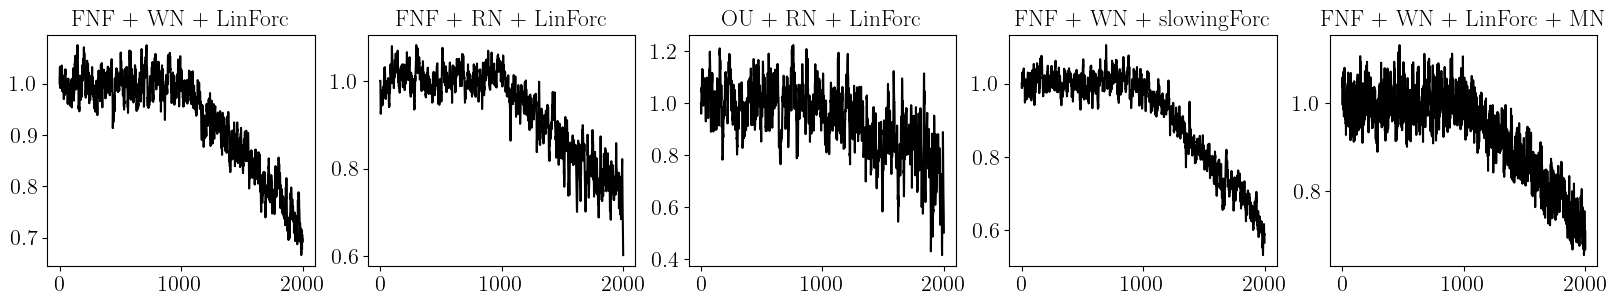

In [48]:
show_sample = 0
titles = ["FNF + WN + LinForc","FNF + RN + LinForc","OU + RN + LinForc","FNF + WN + slowingForc","FNF + WN + LinForc + MN"]
samples = [samples_fnf_wn_linforc[show_sample], samples_fnf_rn_linforc[show_sample], samples_ou_rn_linforc[show_sample], samples_fnf_wn_slowforc[show_sample],  samples_fnf_wn_linforc_mn[show_sample]]
fig, axs = plt.subplots(1,len(samples), figsize=(4*len(samples),3))
for i in range(len(samples)):
    axs[i].plot(samples[i],c="black")
    axs[i].set_title(titles[i], fontsize=17)
plt.show()

## Plot results obtained from the R script
### Figure 1

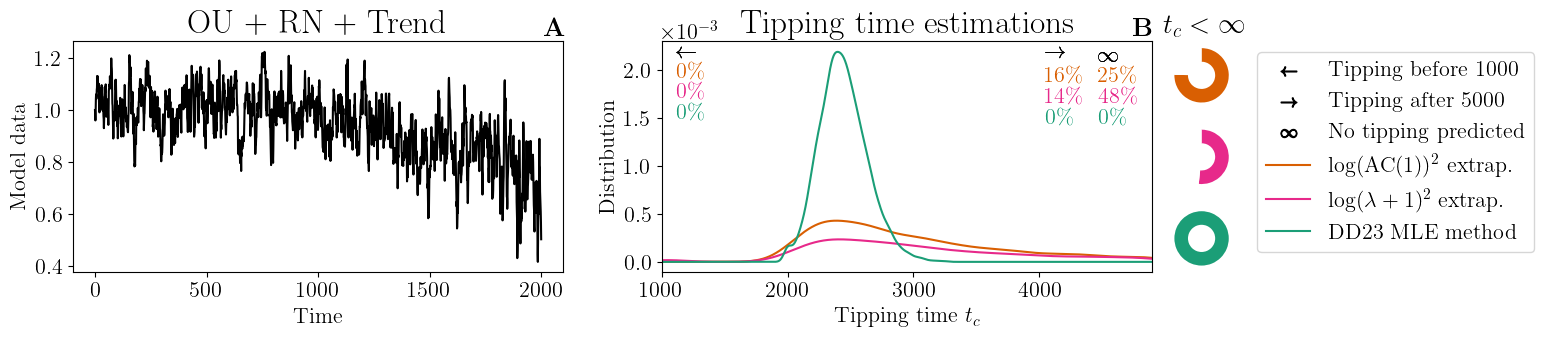

In [49]:
show_sample = 0
title = "OU + RN + Trend"
methodnames = ["ac1_log_sq","gls_log_sq","dd23"]
methoddescrips = ["$\log(\mathrm{AC}(1))^2$ extrap.",r"$\log(\lambda+1)^2$ extrap.", "DD23 MLE method"]
sample = samples_ou_rn_linforc[show_sample]
t_left = 1000
t_right = 5000
t_step = 100
kde_disp = False
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e6-1,1e20])))
fig = plt.figure(figsize=(19,3))
gs = mpl.gridspec.GridSpec(1, 5, width_ratios=[1,0.2,1,0.2,0.6], height_ratios=[1])
gs.update(wspace = 0, hspace = 0)

ax0 = plt.subplot(gs[0])
hiddenax = plt.subplot(gs[1])
ax1 = plt.subplot(gs[2])
sgs = gs[3].subgridspec(3,1)
ax20 = plt.subplot(sgs[0])
ax21 = plt.subplot(sgs[1])
ax22 = plt.subplot(sgs[2])
ax3 = plt.subplot(gs[4])
donut_axs = [ax20,ax21,ax22]
donut_colors = ['#d95f02','white', '#e7298a','white','#1b9e77', 'white']

hiddenax.axis("off")

#plt.rcParams.update({'text.usetex': True})
fig.text(0.699,0.91,"$t_c<\infty$", fontsize=20)
#plt.rcParams.update({'text.usetex': False})
ax0.plot(sample, c="black")
ax0.set_title(title)
ax0.set_xlabel("Time")
ax0.set_ylabel("Model data")
for j in range(len(methodnames)):
    t_c_values = np.array(pd.read_excel("TipEstimResults_ou_rn_linforc.xlsx").loc[:,methodnames[j]])
    samplesize = len(t_c_values)

    if kde_disp == True:
        hist = ax1.hist(t_c_values,bins=bins,histtype="step",density=False,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])[0]
    else:
        hist = np.histogram(t_c_values,bins=bins,density=False)[0]
        t_c_values = t_c_values[np.where(t_c_values<t_right+1)]
        t_c_values = t_c_values[np.where(t_c_values>t_left-1)]
        if len(t_c_values)<=10:
            t_c_values = np.linspace(0,1,samplesize)
        kde = stats.gaussian_kde(t_c_values)
        ax1.plot(range(t_left,t_right),kde(range(t_left,t_right))*len(t_c_values)/samplesize,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])

    ax1.text(0.03,0.91,r"$\leftarrow$",color="black", transform=ax1.transAxes)
    ax1.text(0.03,0.84-j*0.09,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=ax1.transAxes)
    ax1.text(0.78,0.91,r"$\rightarrow$",color="black", transform=ax1.transAxes)
    ax1.text(0.78,0.82-j*0.09,str(round(hist[-2]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=ax1.transAxes)
    ax1.text(0.89,0.91,r"$\infty$",color="black", transform=ax1.transAxes)
    ax1.text(0.89,0.82-j*0.09,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=ax1.transAxes)


    ax = donut_axs[j]
    these_colors = [donut_colors[2*j],donut_colors[2*j+1]]
    finite_infinite = [sum(hist[:-1]), sum(hist[-1:])]
    ax.pie(finite_infinite, wedgeprops=dict(width=0.5), startangle=90,colors=these_colors, counterclock=False)
ax1.set_xlim(t_left,t_right-t_step)
ax1.set_title("Tipping time estimations")
ax1.set_xlabel("Tipping time $t_c$")
ax1.set_ylabel("Distribution")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(-1,1))


ax3.scatter([0],[0],marker=r"$\leftarrow$",c="black")
ax3.scatter([0],[0],marker=r"$\rightarrow$",c="black")
ax3.scatter([0],[0],marker=r"$\infty$",c="black")
for i in range(len(methodnames)):
    ax3.plot([0,1],[0,1],c=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
ax3.set_ylim(-1,-0.5)
ax3.legend([ "Tipping before "+str(t_left), "Tipping after "+str(t_right), "No tipping predicted"]+methoddescrips,loc="upper right", markerscale=2)
ax3.axis("off")
ax0.text(0.96,1.025,r"$\bf "+figlabels[0]+"$",color="black", transform=ax0.transAxes, fontsize=19)
ax1.text(0.96,1.025,r"$\bf "+figlabels[1]+"$",color="black", transform=ax1.transAxes, fontsize=19)

plt.savefig("Plots/lineargeneralmodel_" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()

### Figure 2

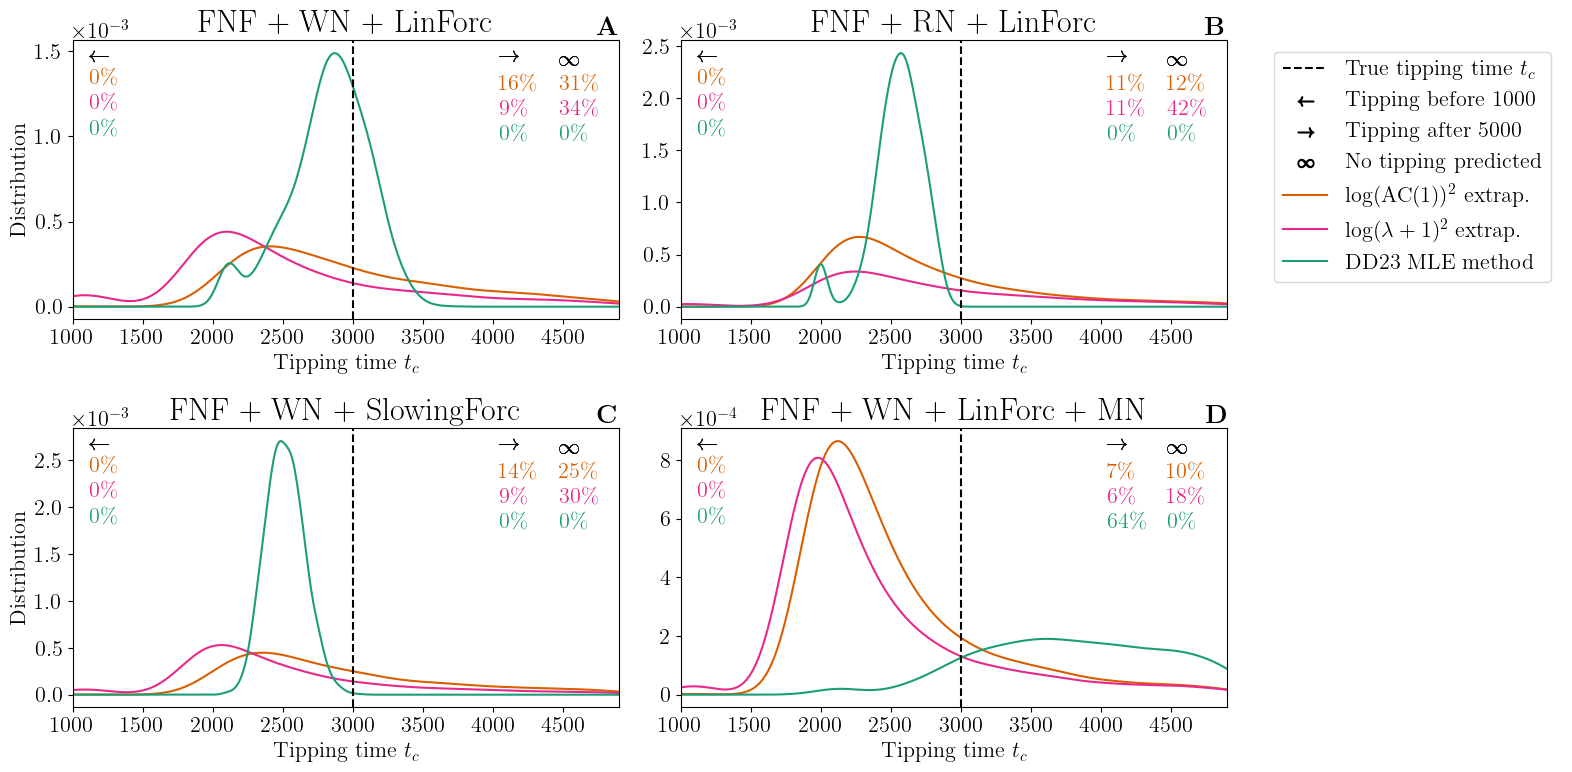

In [50]:
modelnames= ["fnf_wn_linforc","fnf_rn_linforc","ou_rn_linforc","fnf_wn_slowforc","fnf_wn_linforc_mn"]
methodnames = ["ac1_log_sq","gls_log_sq","dd23"]
t_left = 1000
t_right = 5000
t_step = 100
kde_disp = False
modeldescrips = ["FNF + WN + LinForc","FNF + RN + LinForc","OU + RN + Trend","FNF + WN + SlowingForc","FNF + WN + LinForc + MN"]
methoddescrips = ["$\log(\mathrm{AC}(1))^2$ extrap.",r"$\log(\lambda+1)^2$ extrap.", "DD23 MLE method"]
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(16,8),tight_layout=False, gridspec_kw={'width_ratios': [1, 1, 0.5]})
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e6-1,1e20])))
for i in [0,1,3,4]:
    axs[i].set_xlabel("Tipping time $t_c$")
    for j in range(len(methodnames)):
        t_c_values = np.array(pd.read_excel("TipEstimResults_"+modelnames[i]+".xlsx").loc[:,methodnames[j]])
        samplesize = len(t_c_values)
        if kde_disp == True:
            hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False)[0]
        else:
            hist = np.histogram(t_c_values,bins=bins,density=False)[0]
            t_c_values = t_c_values[np.where(t_c_values<t_right+1)]
            t_c_values = t_c_values[np.where(t_c_values>t_left-1)]
            if len(t_c_values)<=10:
                t_c_values = np.linspace(0,1,samplesize)
            kde = stats.gaussian_kde(t_c_values,0.25)
            axs[i].plot(range(t_left,t_right),kde(range(t_left,t_right))*len(t_c_values)/samplesize,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])

        axs[i].text(0.03,0.91,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
        axs[i].text(0.03,0.84-j*0.09,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=axs[i].transAxes)
        axs[i].text(0.78,0.91,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
        axs[i].text(0.78,0.82-j*0.09,str(round(hist[-2]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=axs[i].transAxes)
        axs[i].text(0.89,0.91,r"$\infty$",color="black", transform=axs[i].transAxes)
        axs[i].text(0.89,0.82-j*0.09,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], transform=axs[i].transAxes)
    axs[i].set_xlim(t_left,t_right-t_step)
    axs[i].ticklabel_format(axis="y", style="sci", scilimits=(-1,1))
    axs[i].set_title(modeldescrips[i], fontsize=23)
    if i in [0,1,3,4]:
        axs[i].axvline(t_0+tau_rs[modelnames[i]],c="black",linestyle="dashed")
    else:
        axs[i].text(0.35,0.9,"no tipping ahead",c="black", transform=axs[i].transAxes)
    axs[i].text(0.96,1.02,r"$\bf "+figlabels[i]+"$",color="black", transform=axs[i].transAxes, fontsize=19)
axs[0].set_ylabel("Distribution")
axs[3].set_ylabel("Distribution")
axs[2].plot([0,1],[0,1],c="black",linestyle="dashed")
axs[2].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[2].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[2].scatter([0],[0],marker=r"$\infty$",c="black")
for i in range(len(methodnames)):
    axs[2].plot([0,1],[0,1],c=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
axs[2].set_ylim(-1,-0.5)
axs[2].legend(["True tipping time $t_c$", "Tipping before "+str(t_left), "Tipping after "+str(t_right), "No tipping predicted"]+methoddescrips, loc="upper right", markerscale=2)
axs[len(modelnames)].axis("off")
axs[2].axis("off")
plt.subplots_adjust(wspace=0.1)
plt.savefig("Plots/allgeneralmodels_" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()